# Model Exploration

This document is a Python exploration of this R-based document: http://m-clark.github.io/data-processing-and-visualization/.  It is intended for those new to modeling and related concepts.  Code is *not* optimized for anything but learning.  In addition, all the content is located with the main document, not here, so many sections may not be included.  I only focus on reproducing the code chunks.

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

## Linear Models

A typical way to depict a linear regression model is as follows:


$$y = b_0 + b_1\cdot x_1 + b_2\cdot x_2 + ... +  + b_p\cdot x_p + \epsilon$$

In the above, $b_0$ is the intercept, and the other $b_*$ are the regression coefficients that represent the relationship of the predictors $x$ to the target variable $y$.  The $\epsilon$ represents the *error* or *residual*.  We don't have perfect prediction, and that represents the difference between what we can guess with our predictor relationships to the target and what we actually observe with it.

In Python, we specify a linear model as we would in R using [the formula api](https://www.statsmodels.org/devel/example_formulas.html).  There are various inputs, typically starting with the formula. In the formula, The target variable is first, followed by the predictor variables, separated by a tilde (`~`). Additional predictor variables are added with a plus sign (`+`).  In this example, `y` is our target, and the predictors are `x` and `z`.

In [2]:
'y ~ x'

'y ~ x'

Generally in Python, model fitting is done in two steps, where the model is first specified, then subsequently fit.

In [3]:
# mod = smf.ols(formula='y ~ x', data = df)

# res = mod.fit()

We can add things like interactions or convert variable types within the formula.

In [4]:
# mod = smf.ols(formula='y ~ x + z + x:z', data = df)
# mod = smf.ols(formula='y ~ x + C(z)', data = df)  # convert z to categorical

## Estimation

### Loss

The goal of many estimation approaches is the reduction of *loss*, conceptually defined as the difference between the model predictions and the observed data, i.e. prediction error. In an introductory methods course, many are introduced to *ordinary least squares* as a means to estimate the coefficients for a linear regression model.  In this scenario, we are seeking to come up with estimates of the coefficients that minimize the (squared) difference between the observed target value and the fitted value based on the parameter estimates.  The loss in this case is defined as the sum of the squared errors.  Formally we can state it as follows.

$$\mathcal{Loss} = \Sigma(y - \hat{y})^2$$

We can see how this works more clearly with some simple conceptual code.  In what follows, we create a function, allows us to move row by row through the data, calculating both our prediction based on the given model parameters- $\hat{y}$, and the difference between that and our target variable $y$.  We sum these squared differences to get a total. In practice such a function is called the loss function, cost function, or objective function.

In [5]:
import numpy as np

In [6]:
def ls_loss(X, y, beta):
    N = X.shape[0]
    loss  = np.repeat(0., N)
    y_hat = np.repeat(0., N)
    
    for n in range(N):
        y_hat[n] = np.sum(X[n]*beta)
        loss[n]  = (y[n] - y_hat[n])**2
    
    return(np.sum(loss))

Now we need some data. Let's construct some data so that we know the true underlying values for the regression coefficients. Feel free to change the sample size `N` or the coefficient values.

In [7]:
np.random.seed(123)           # for reproducibility

N = 100                       # Sample size
X = np.c_[np.repeat(1, N), np.random.normal(size = N)]  # a model matrix; first column represents the intercept
y = 5 * X[:, 0] + .5 * X[:, 1] + np.random.normal(size = N)  # a target with some noise; truth is y = 5 +.5*x

df = pd.DataFrame(np.c_[y, X[:,1]], columns = ['y', 'x'])
df.head()

,y,x
0,5.099239,-1.085631
1,3.520785,0.997345
2,5.853754,0.282978
3,6.845157,-1.506295
4,4.686074,-0.578600


In [8]:
ls_loss(X, y, beta = [0., 1.])    # guess 1

2595.055066494441

In [9]:
ls_loss(X, y, beta = [1., 2.])    # guess 2

1939.0482563455128

In [10]:
ls_loss(X, y, beta = [4., .25])   # guess 3

198.46475152607633

In [11]:
f = smf.ols('y ~ x', df)          # fit the model and obtain parameter estimates using OLS
model = f.fit()

In [12]:
model.params                      # best guess given the data 

Intercept    4.980914
x            0.483407
dtype: float64

In [13]:
np.sum(model.resid**2)            # least squares loss

94.06535118757606

In [14]:
ls_loss(X, y, model.params)

94.06535118757606

In some relatively rare cases, a known approach is available and we do not have to search for the best estimates, but simply have to perform the correct steps that will result in them.  For example, the following matrix operations will produce the best estimates for linear regression, which also happen to be the maximum likelihood estimates.

In [15]:
np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)  # 'normal equations'

array([4.98091425, 0.48340745])

Many statistical modeling techniques use *maximum likelihood* in some form or fashion, including Bayesian approaches, so you would do well to understand the basics. In this case, instead of minimizing the loss, we use an approach to maximize the probability of the observations of the target variable given the estimates of the parameters of the model (e.g. the coefficients in a regression)

Again, some simple conceptual code can help us. The next bit of code follows a similar approach to what we had with least squares regression, but the goal is instead to maximize the likelihood of the observed data. In this example, I fix the estimated variance, but in practice we'd need to estimate that parameter as well.  As probabilities are typically very small, we work with them on the log scale.

In [16]:
from scipy.stats import norm

def max_like(X, y, beta, sigma = 1):
    N = X.shape[0]
    likelihood  = np.repeat(0., N)
    y_hat = np.repeat(0., N)
    
    for n in range(N):
        y_hat[n] = np.sum(X[n]*beta)
        likelihood[n]  = norm.logpdf(y[n], y_hat[n], 1)
    
    return(np.sum(likelihood))

In [17]:
max_like(X, y, beta = [0., 1.])    # guess 1

-1389.4213865676875

In [18]:
max_like(X, y, beta = [1., 2.])    # guess 2

-1061.4179814932236

In [19]:
max_like(X, y, beta = [4., .25])   # guess 3

-191.12622908350542

In [20]:
model.llf

-138.8348323266888

In [21]:
max_like(X, y, model.params)  # difference as estimated sigma is not 1.0

-138.9265289142553

## Fitting Models

When using `statsmodels` the primary components required to fit a model are the model formula, and a data frame that contains the variables specified in that formula.  Consider the following models. In general the syntax is the similar regardless of package, with special considerations for the type of model. The data argument is not included in these examples, but would be needed.

In [22]:
# glm
# model = smf.glm(formula, family = sm.families.Binomial())

In [23]:
# poisson with offset
# model = smf.glm(
#     formula, 
#     family = sm.families.Poisson(), 
#     exposure = np.asarray(data['exposure_var']))


In [24]:
# mixed models
# model = smf.mixedlm(formula, groups = data["group_var"])

Let's finally get our hands dirty and run an example. We'll use the world happiness dataset. This is country level data based on surveys taken at various years, and the scores are averages or proportions, along with other values like GDP.  

In [25]:
happy = pd.read_csv('../data/world_hapiness.csv')

happy.describe()

,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government,democratic_quality,delivery_quality,gini_index_world_bank_estimate,happiness_score,dystopia_residual
count,1704.000000,1704.000000,1676.000000,1691.000000,1676.000000,1675.000000,1622.000000,1608.000000,1685.000000,1691.000000,1530.000000,1558.000000,1559.000000,643.000000,554.000000,554.000000
mean,2012.332160,5.437155,9.222456,0.810570,63.111971,0.733829,0.000079,0.751315,0.709368,0.265679,0.481973,-0.136053,-0.001390,0.370000,5.410409,2.059861
std,3.688072,1.121149,1.185794,0.119210,7.583622,0.144115,0.163365,0.186074,0.107984,0.084707,0.192059,0.876074,0.975849,0.083232,1.130121,0.550848
min,2005.000000,2.661718,6.457201,0.290184,32.299999,0.257534,-0.336385,0.035198,0.362498,0.083426,0.068769,-2.448228,-2.144974,0.240000,2.693000,0.291651
25%,2009.000000,4.610970,8.304428,0.747512,58.299999,0.638436,-0.115534,0.696083,0.621855,0.205414,0.334735,-0.790461,-0.711416,0.305000,4.513250,1.723459
50%,2012.000000,5.339557,9.406206,0.833098,65.000000,0.752731,-0.022080,0.805775,0.718541,0.254544,0.464109,-0.227386,-0.218633,0.352000,5.312500,2.064439
75%,2015.000000,6.273522,10.193060,0.904432,68.300003,0.848155,0.093522,0.876458,0.801530,0.314896,0.614862,0.650468,0.699971,0.428000,6.323525,2.436582
max,2018.000000,8.018934,11.770276,0.987343,76.800003,0.985178,0.677743,0.983276,0.943621,0.704590,0.993604,1.575009,2.184725,0.634000,7.632100,3.837715


Fitting a model with statsmodels and a pandas data frame is pretty easy, and at a minimum requires the two key ingredients mentioned before, the formula and data.

In [26]:
happy_model_base = smf.ols(
  'happiness_score ~ democratic_quality + generosity + log_gdp_per_capita',
  data = happy
).fit()

### Using Matrices

Unlike R, many if not most Python modeling approaches will expect matrix input rather than a formula + data frame, so you should feel comfortable with that approach. For example, we can use sm.ols as before, and as we did, we'd  need to create the required components.  

In [27]:
sm.OLS(y, X).fit()

## Summarizing Models

Once we have a model, we'll want to summarize the results of it. Most modeling packages have a summary method we can apply, which will provide parameter estimates, some notion of model fit, inferential statistics, and other output.

In [28]:
happy_model_base_sum = happy_model_base.summary()

happy_model_base_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     309.6
Date:                Mon, 24 Feb 2020   Prob (F-statistic):          1.24e-104
Time:                        17:34:57   Log-Likelihood:                -390.15
No. Observations:                 411   AIC:                             788.3
Df Residuals:                     407   BIC:                             804.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0105      0.314     -3.214      0.001      -1.628      -0.393
democratic_quality     0.1704      0.046      3.714      0.000       0.080       0.261
generosity             1.1608      0.195      5.938      0.000       0.777       1.545
log_gdp_per_capita     0.6934      0.033     20.792      0.000       0.628       0.759
==============================================================================
Omnibus:                        3.428   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.731
Skew:                           0.075   Prob(JB):                        0.255
Kurtosis:                       2.630   Cond. No.                         96.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary provides several pieces of information: the coefficients or weights (`coef`), the standard errors (`std err`), the t-statistic (which is just the coefficient divided by the standard error), and the corresponding p-value.  The main thing to look at are the actual coefficients and the direction of their relationship, positive or negative. For example, with regard to the effect of democratic quality, moving one point on democratic quality results in roughly .17 units of happiness.

One thing we must also have in order to understand our results is to get a sense of the uncertainty in the effects.  The summary provides confidence intervals for each of the coefficients, and with them, we have a sense of the range of plausible values for the coefficients. We can also obtain it as follows.

In [29]:
happy_model_base.conf_int()

,0,1
Intercept,-1.628455,-0.392500
democratic_quality,0.080188,0.260559
generosity,0.776562,1.545131
log_gdp_per_capita,0.627862,0.758981


The value we actually estimate is the best guess given our circumstances, but slight changes in the data, the way we collect it, the time we collect it, etc., all would result in a slightly different result. The confidence interval provides a range of what we could expect given the uncertainty, and, given its importance, you should always report it.  In fact, just showing the coefficient and the interval would be better than typical reporting of the statistical test results, though you can do both.

## Variable Transformations

Transforming variables can provide a few benefits, whether applied to the target, covariates, or both, and should regularly be used for most models. Some of these benefits include:

- Interpretable intercepts
- More comparable covariate effects
- Faster estimation
- Easier convergence
- Help with heteroscedasticity

For example, merely centering predictor variables, i.e. subtracting the mean, provides a more interpretable intercept that will fall within the actual range of the target variable, telling us what the value of the target variable is when the covariates are at their means (or reference value if categorical).  

### Numeric variables

Two extremely common transformations applied to numeric variables- logging and scaling.  We can, and typically should apply these to the data beforehand, and this will usually be done with `numpy` and other tools.  You can do them in statsmodels formulas though also.

In [30]:
smf.ols(
  'happiness_score ~ np.log(democratic_quality) + generosity + log_gdp_per_capita',
  data = happy
)

/Users/micl/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Categorical variables

A raw character string is not an analyzable unit, so character strings and labeled variables like factors must be converted for analysis to be conducted on them. For categorical variables, we can employ what is called *effects coding* to test for specific types of group differences.  Far and away the most common approach is called *dummy coding* or *one-hot encoding*.  In the next example, we will use dummy coding via pandas.  statsmodels will recognize the categorical type from the pandas data frame and do the coding behind the scenes.

In [31]:
nafta = happy[happy.country.isin(['United States', 'Canada', 'Mexico'])]
nafta.head()

,country,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government,democratic_quality,delivery_quality,gini_index_world_bank_estimate,happiness_score,dystopia_residual
258,Canada,2005,7.418048,10.608347,0.961552,71.300003,0.957306,0.244575,0.502681,0.838544,0.233278,0.442818,1.168249,1.748819,NaN,NaN,NaN
259,Canada,2007,7.481753,10.636994,NaN,71.660004,0.930341,0.241932,0.405608,0.871604,0.256810,0.637824,1.195769,1.795603,0.338,NaN,NaN
260,Canada,2008,7.485604,10.636126,0.938707,71.839996,0.926315,0.254044,0.369588,0.890220,0.202175,0.590371,1.224689,1.813375,NaN,NaN,NaN
261,Canada,2009,7.487824,10.594738,0.942845,72.019997,0.915058,0.238822,0.412622,0.867433,0.247633,0.608264,1.264292,1.827809,NaN,NaN,NaN
262,Canada,2010,7.650346,10.613968,0.953765,72.199997,0.933949,0.223002,0.412660,0.878868,0.233113,0.551076,1.144457,1.838644,0.336,NaN,NaN


In [32]:
smf.ols('happiness_score ~ country', data = nafta).fit().summary()

/Users/micl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     10.11
Date:                Mon, 24 Feb 2020   Prob (F-statistic):            0.00499
Time:                        17:34:57   Log-Likelihood:                 4.4602
No. Observations:                  12   AIC:                            -2.920
Df Residuals:                       9   BIC:                            -1.466
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.3689      0.096     76.493      0.000       7.151       7.587
country[T.Mexico]           -0.6111      0.136     -4.485      0.002      -0.919      -0.303
country[T.United States]    -0.3434      0.136     -2.520      0.033      -0.652      -0.035
==============================================================================
Omnibus:                        6.533   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                2.715
Skew:                           0.937   Prob(JB):                        0.257
Kurtosis:                       4.384   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this case, the coefficient represents the difference in means on the target variable between the reference group and the group in question.  In this case, the U.S. is .34 less on the happy score than the reference country (Canada).

Other codings are possible, and these would allow for specific group comparisons or types of comparisons.  This is sometimes called *contrast coding*.  For example, we could compare each group to the overall mean using [Sum coding](https://www.statsmodels.org/dev/contrasts.html).

In [33]:
from patsy.contrasts import Sum

levels = [1,2,3]
contrast = Sum().code_without_intercept(levels)

print(contrast.matrix)

smf.ols('happiness_score ~ C(country, Sum)', data = nafta).fit().summary()

[[ 1.  0.]
 [ 0.  1.]
 [-1. -1.]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     10.11
Date:                Mon, 24 Feb 2020   Prob (F-statistic):            0.00499
Time:                        17:34:57   Log-Likelihood:                 4.4602
No. Observations:                  12   AIC:                            -2.920
Df Residuals:                       9   BIC:                            -1.466
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     7.0507      0.056    126.769      0.000       6.925       7.177
C(country, Sum)[S.Canada]     0.3181      0.079      4.045      0.003       0.140       0.496
C(country, Sum)[S.Mexico]    -0.2929      0.079     -3.724      0.005      -0.471      -0.115
==============================================================================
Omnibus:                        6.533   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                2.715
Skew:                           0.937   Prob(JB):                        0.257
Kurtosis:                       4.384   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


## Extracting Output

The better you get at modeling, the more often you are going to need to get at certain parts of the model output easily.  For example, we can extract the coefficients, residuals, model data and other parts from standard linear model objects from a statsmodels object.


Why would you want to do this?  A simple example would be to compare effects across different settings. We can collect the values, put them in a data frame, and then to a table or visualization.

Typical modeling methods/attributes you might want to use:

- **summary**: print results in a legible way
- **predict**: make predictions, possibly on new data
- **conf_int**: get confidence intervals for parameters
- **params**: extract coefficients
- **fittedvalues**: extract fitted values
- **resid**: extract residuals
- **aic**: extract AIC
- **rsquared_adj**: adjusted R**2
- **mse_resid**: mean squared error residual

In [34]:
happy_model_base.aic

788.2967012572146

In [35]:
happy_model_base.predict(happy[:5])

0    3.838179
1    3.959046
2    3.928180
3    4.004129
4    4.171624
dtype: float64

In [36]:
happy_model_base.mse_resid

0.39472541113224174

## Visualization

Python and/or statsmodels doesn't have a lot going for visualizations of models unfortunately, but there are a few tools for exploration.  See a [list here](https://www.statsmodels.org/devel/graphics.html).  You can get partial regression and component plus residual plots, among others.  These are great for a quick look at what's going on, but you'll likely need to get your hands dirty to get anything presentable.

In [1]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(happy_model_base, 'generosity', fig = fig)
plt.show()

NameError: name 'sm' is not defined

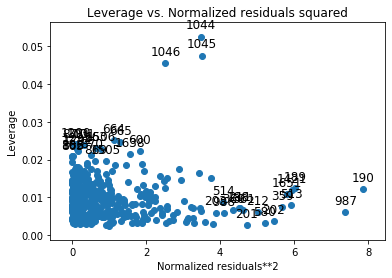

In [38]:
sm.graphics.plot_leverage_resid2(happy_model_base) # spot potential problematic observations your model fails to explain.
plt.show()

## Extensions to the Linear Model

### Different types of targets

In many data situations, we do not have a continuous numeric target variable, or may want to use a different distribution to get a better fit, or adhere to some theoretical perspective.  For example, count data is not continuous and often notably skewed, so assuming a normal symmetric distribution may not work as well. From a data generating perspective we can use the Poisson distribution for the target variable instead.  

$$\ln{\mu} =  X\beta$$

$$\mu = e^{X\beta}$$

$$y \sim \mathcal{Pois}(\mu)$$

Conceptually nothing has really changed from what we were doing with the standard linear model, except for the distribution.  We still have a mean function determined by our predictors, and this is what we're typically mainly interested in from a theoretical perspective.  We do have an added step, a transformation of the mean (now usually called the *linear predictor*).  Poisson naturally works with the log of the target, but rather than do that explicitly, we instead exponentiate the linear predictor.  The *link function*, which is the natural log in this setting, has a corresponding  *inverse link* (or mean function)- exponentiation.

In code we can demonstrate this as follows similar to how we did before

In [39]:
np.random.seed(123)                  # for reproducibility
N = 1000                             # sample size
beta = [2, 1]                        # the true coefficient values
x = np.random.normal(size = N)       # a single predictor variable
mu = np.exp(beta[0] + beta[1]*x)     # the linear predictor
y = np.random.poisson(size = N, lam = mu)         # the target variable lambda = mean

df = pd.DataFrame({'y': y, 'x':x})
df.head()

,y,x
0,2,-1.085631
1,23,0.997345
2,10,0.282978
3,2,-1.506295
4,1,-0.578600


In [40]:
smf.glm('y ~ x', data = df, family = sm.families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2389.9
Date:                Mon, 24 Feb 2020   Deviance:                       1066.3
Time:                        17:34:58   Pearson chi2:                 1.03e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0028      0.013    156.789      0.000       1.978       2.028
x              1.0027      0.009    108.427      0.000       0.985       1.021
==============================================================================
"""

A very common setting is the case where our target variable takes on only two values- yes vs. no, alive vs. dead, etc.  The most common model used in such settings is the logistic regression model.  In this case, it will have a different link to go with a different distribution.

$$\ln{\frac{\mu}{1-\mu}} =  X\beta$$

$$\mu = \frac{1}{1+e^{-X\beta}}$$

$$y \sim \mathcal{Binom}(\mathrm{prob}=\mu, \mathrm{size} = 1)$$


Here our link function is called the *logit*, and it's inverse takes our linear predictor and puts it on the probability scale.

Again, some code can help drive this home.


In [41]:
mu = 1 / (1 + np.exp(-(beta[0] + beta[1]*x)))
y = np.random.binomial(size = N, n = 1, p = mu)

df = pd.DataFrame({'y': y, 'x': x})
df.head()

,y,x
0,1,-1.085631
1,1,0.997345
2,1,0.282978
3,1,-1.506295
4,1,-0.578600


In [42]:
smf.glm('y ~ x', data = df, family = sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -391.14
Date:                Mon, 24 Feb 2020   Deviance:                       782.28
Time:                        17:34:58   Pearson chi2:                     978.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9580      0.109     18.003      0.000       1.745       2.171
x              0.9962      0.103      9.646      0.000       0.794       1.199
==============================================================================
"""

You'll have noticed that when we fit these models we used `glm` instead of `ols`. The normal linear model is a special case of *generalized linear models*, which includes a specific class of distributions- normal, poisson, binomial, gamma, beta and more- collectively referred to as the [exponential family](https://en.wikipedia.org/wiki/Exponential_family).  While this family can cover a lot of ground, you do not have to restrict yourself to it, and other modules will provide access to more options.  The main point is that you have tools to deal with continuous, binary, count, ordinal, and other types of data.  Furthermore, not much necessarily changes conceptually from model to model besides the link function and/or distribution.

### Correlated data

Often in standard regression modeling situations we have data that is correlated, like when we observe multiple observations for individuals (e.g. longitudinal studies), or observations are clustered within geographic units.  There are many ways to analyze all kinds of correlated data in the form of clustered data, time series, spatial data and similar. In terms of understanding the mean function and data generating distribution for our target variable, as we did in our previous models, not much changes.  However, we will want to utilize estimation techniques that take this correlation into account.  Examples of such models include:

- Mixed models (e.g. random intercepts, 'multilevel' models)
- Time series models (autoregressive)
- Spatial models (e.g. conditional autoregressive)

As demonstration is beyond the scope of this document, the main point here is awareness. But see the statsmodels docs on [mixed models](https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html) and [many others](https://www.statsmodels.org/devel/user-guide.html#regression-and-linear-models).

### Other extensions

There are many types of models that will take one well beyond the standard linear model.  In some cases, the focus is multivariate, trying to model many targets at once. Other models will even be domain-specific, tailored to a very narrow type of problem. Whatever the scenario, having a good understanding of the models we've been discussing will likely help you navigate these new waters much more easily.